In [87]:
import tensorflow as tf
from  tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [88]:
# Implement Fully Connected Layer as FCLayer(Dense)
class FCLayer:
    def __init__(self, input_size, output_size):
      # input_size = number of input neurons
      # output_size = number of output neurons
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(input_size, output_size) / np.sqrt(input_size + output_size)
        self.bias = np.random.randn(1, output_size) / np.sqrt(input_size + output_size)

    # returns output for a given input
    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # bias_error = output_error
        
        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [89]:
class ActivationLayer:
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime
    
    #returns the activated input
    def forward(self, input):
        self.input = input
        return self.activation(input)
    
    def backward(self, output_error, learning_rate):
        return output_error * self.activation_prime(self.input)

In [90]:
class FlattenLayer:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def forward(self, input):
        return np.reshape(input, (1, -1))
    
    def backward(self, output_error, learning_rate):
        return np.reshape(output_error, self.input_shape)

In [91]:
class SoftmaxLayer:
    def __init__(self, input_size):
        self.input_size = input_size
    
    def forward(self, input):
        self.input = input
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_error, learning_rate):
        input_error = np.zeros(output_error.shape)
        out = np.tile(self.output.T, self.input_size)
        return self.output * np.dot(output_error, np.identity(self.input_size) - out)

##Activation Funcrion

In [92]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(x, 0)

def relu_prime(x):
    return np.array(x >= 0).astype('int')

##Lost Function

In [93]:
# Mean Squared Error
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_pred.size

def sse(y_true, y_pred):
    return 0.5 * np.sum(np.power(y_true - y_pred, 2))

def sse_prime(y_true, y_pred):
    return y_pred - y_true

In [94]:
mnist = tf.keras.datasets.mnist

(train_images, train_lables), (test_images, test_lables) = mnist.load_data()

In [95]:
train_images.shape

(60000, 28, 28)

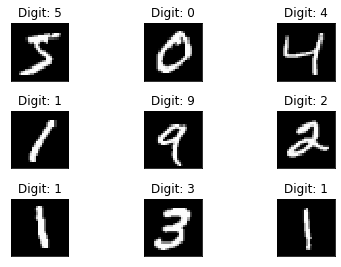

In [96]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(train_images[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(train_lables[i]))
  plt.xticks([])
  plt.yticks([])

In [98]:
from keras.datasets import mnist
from keras.utils import np_utils

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_train /= 255
y_train = np_utils.to_categorical(y_train)
x_train = x_train[0:1000]
y_train = y_train[0:1000]

x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)

In [102]:
DensNetwork = [
    FlattenLayer(input_shape=(28, 28)),
    FCLayer(28 * 28, 128),
    ActivationLayer(relu, relu_prime),
    FCLayer(128, 10),
    SoftmaxLayer(10)
]

epochs = 10
learning_rate = 0.1

# training
for epoch in range(epochs):
    error = 0
    for x, y_true in zip(x_train, y_train):
        # forward
        output = x
        for layer in DensNetwork:
            output = layer.forward(output)
        
        # error (display purpose only)
        error += mse(y_true, output)

        # backward
        output_error = mse_prime(y_true, output)
        for layer in reversed(DensNetwork):
            output_error = layer.backward(output_error, learning_rate)
    
    error /= len(x_train)
    print('%d/%d, error=%f' % (epoch + 1, epochs, error))

1/10, error=0.072084
2/10, error=0.033519
3/10, error=0.021605
4/10, error=0.016743
5/10, error=0.013781
6/10, error=0.011650
7/10, error=0.009968
8/10, error=0.008599
9/10, error=0.007419
10/10, error=0.006436


In [103]:
def predict(DensNetwork, input):
    output = input
    for layer in DensNetwork:
        output = layer.forward(output)
    return output

ratio = sum([np.argmax(y) == np.argmax(predict(DensNetwork, x)) for x, y in zip(x_test, y_test)]) / len(x_test)
error = sum([mse(y, predict(DensNetwork, x)) for x, y in zip(x_test, y_test)]) / len(x_test)
print('ratio: %.2f' % ratio)
print('Mean Squre Error: %.4f' % error)

ratio: 0.86
Mean Squre Error: 0.0211
